# Calibration of the Chaboche mecanical model

## Abstract

The goal of this example is to present the statistical hypotheses of the calibration of the chaboche model. More precisely, this example shows how the observations in the "calibration-chaboche-observations.csv" were generated.

## Thanks to

- Antoine Dumas, Phiméca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.


## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = G(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$
where 

- $\epsilon$ is the strain,
- $\sigma$ is the stress (Pa),
- $R$, $C$, $\gamma$ are the parameters.

The variables have the following distributions and are supposed to be independent.

| Random var. | Distribution | 
|--|--|
| $R$ | Lognormale ($\mu = 750$ MPa, $\sigma = 11$) |
| $C$ | Normale ($\mu = 2750$ MPa, $\sigma = 250$) |
| $\gamma$ | Normale ($\mu = 10$, $\sigma = 2$) |
| $\epsilon$ | Uniforme(a=0, b=0.07). |

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (R,C,\gamma).
$$
We set :

- $R = 750\times 10^6$,
- $C = 2750\times 10^6$,
- $\gamma = 10$.

## Observations

In order to create a calibration problem, we make the hypothesis that the strain has the following distribution:
$$
\epsilon \sim Uniform(0,0.07).
$$

Moreover, we consider a gaussian noise on the observed constraint:
$$
\epsilon_\sigma \sim \mathcal{N} \left(0,40\times 10^6\right)
$$
and we make the hypothesis that the observation errors are independent.
We set the number of observations to:
$$
n = 100.
$$
We generate a Monte-Carlo samplg with size $n$:
$$
\sigma_i = G(\epsilon_i,R,C,\gamma) + (\epsilon_\sigma)_i, 
$$
for $i = 1,..., n$.
The observations are the couples $\{(\epsilon_i,\sigma_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the strain and the corresponding stress.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
# The function G
def modeleChaboche(X):
    strain,R,C,gamma = X
    stress = R + C*(1-np.exp(-gamma*strain))
    return [stress]

# Creation of the problem function
g = ot.PythonFunction(4, 1, modeleChaboche) 

In [3]:
# Random vector definition
Strain = ot.Uniform(0,0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

In [4]:
# Create the joint distribution function
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

In [5]:
# Create the Monte-Carlo algorithm
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputSigma = g(inputSample)
outputSigma[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[1.73052e+09],[2.01764e+09],[9.98458e+08],[8.11861e+08],[1.34312e+09]]

Plot the histogram of the output.

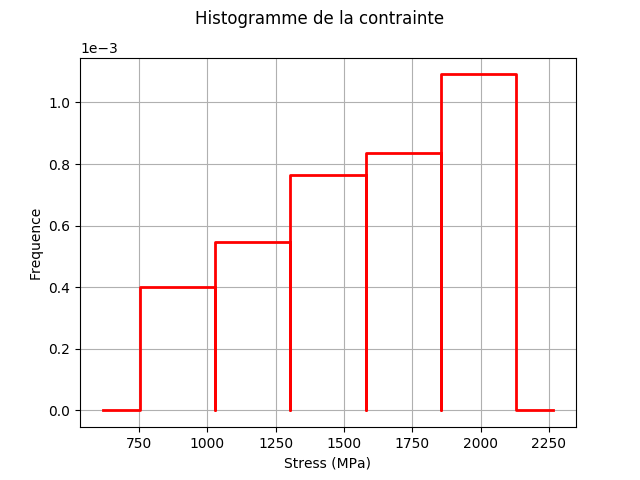

In [6]:
histoGraph = ot.HistogramFactory().build(outputSigma/1.e6).drawPDF()
histoGraph.setTitle("Histogramme de la contrainte")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setYTitle("Frequence")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [7]:
sigmaObservationNoiseSigma = 40.e6 # (Pa)
noiseSigma = ot.Normal(0.,sigmaObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedSigma = outputSigma + sampleNoiseH

In [8]:
observedStrain = inputSample[:,0]

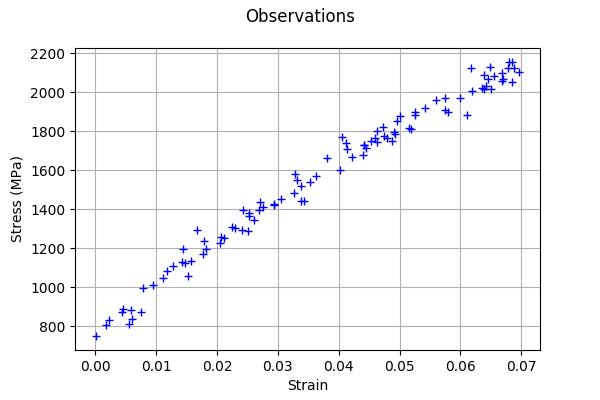

In [9]:
graph = ot.Graph("Observations","Strain","Stress (MPa)",True)
cloud = ot.Cloud(observedStrain,observedSigma/1.e6)
graph.add(cloud)
graph

Create and save sample.

In [10]:
observedSample = ot.Sample(sampleSize,2)
observedSample.setDescription(["Strain","Stress"])
observedSample[:,0] = observedStrain
observedSample[:,1] = observedSigma[:]

#observedSample.exportToCSVFile("calibration_chaboche_observations.csv")